# This is a quick [rasterio](https://github.com/mapbox/rasterio) tutorial 
*Is it compiled using ipython notebook*

The main focus is on Landsat data for scientific applications. We will attempt to calculate some vegetation indices and perform the usual data preparation steps. These include cloud masking, creation of multi-layer raster objects.

## Unpack the data
Landsat surface reflectance data were downloaded from ESPA. ESPA processes Landsat data to surface reflectance using the LEDAPS algorithm and produces a cloud mask using the fmask algorithm. The data is delivered in a tarball which needs to be unpacked.

In [15]:
import tarfile
import re
from os import listdir

# Define variables
data_path = "data/"
tar_grep = re.compile(".*\.tar\.gz$")
bands_grep = re.compile(".*_(B3|B4)\.TIF")

# List files with the tar.gz extension in the data/ directory
tar_list = filter(lambda x: tar_grep.search(x), listdir(data_path))
tar_list = [data_path + s for s in tar_list]

# Open a connection with the first archive (in fact there's only one)
tar = tarfile.open(tar_list[0])
# Retrieve the file names from the archive
file_list = tar.getnames()

# Filter and keep only useful files
bands = filter(lambda x: bands_grep.search(x), file_list)
for item in bands:
    tar.extract(item, path=data_path)
bands = [data_path + s for s in bands]

# See what we've just extracted
print bands

# Close the connection
tar.close()

['data/LT52300712009278COA01_B3.TIF', 'data/LT52300712009278COA01_B4.TIF']


Now that we have extracted the bands required to compute NDVI, we can use `rasterio` to load them and do some calculations with them thanks to `numpy`.

In [60]:
import rasterio
import numpy

# We handle the connections with "with"
with rasterio.open(bands[0]) as src:
    b3 = src.read(1)
    
with rasterio.open(bands[1]) as src:
    b4 = src.read(1)
    
# Prepare zero array to store NDVI
# ndvi = numpy.zeros(b3.shape, dtype=rasterio.float32)

# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

ndvi = (b4.astype(float) - b3.astype(float)) / (b4 + b3)


We can visualize the layer produced.

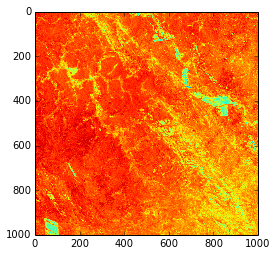

In [62]:
import matplotlib.pyplot as plt
ndvi_sub = ndvi[2000:3000, 2000:3000]
plt.imshow(ndvi_sub)
plt.show()

We can also try to write the file to disk

In [63]:
# Check arrays dimensions

for i in [b3, b4, ndvi]:
    print i.shape
    

(7001, 7961)
(7001, 7961)
(7001, 7961)


In [64]:
# Define spatial characteristics of output object (basically they are analog to the input)
kwargs = src.meta

# Update kwargs (change in data type)
kwargs.update(
        dtype=rasterio.float32,
        count=1,
        compress='lzw')


print kwargs

with rasterio.open('data/ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

{'count': 1, 'crs': {'init': u'epsg:32620'}, 'dtype': 'float32', 'affine': Affine(30.0, 0.0, 501885.0,
       0.0, -30.0, -1651785.0), 'driver': u'GTiff', 'transform': (501885.0, 30.0, 0.0, -1651785.0, 0.0, -30.0), 'height': 7001, 'width': 7961, 'blockxsize': 7961, 'tiled': False, 'blockysize': 1, 'nodata': None, 'compress': 'lzw'}


Let's check it's there and has data.

In [74]:
import subprocess

out_file = listdir(data_path)
out_file = filter(lambda x: re.compile(".*ndvi\.tif").search(x), listdir(data_path))
print subprocess.check_output("gdalinfo " + data_path + out_file[0], shell=True)

Driver: GTiff/GeoTIFF
Files: data/ndvi.tif
Size is 7961, 7001
Coordinate System is:
PROJCS["WGS 84 / UTM zone 20N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-63],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","32620"]]
Origin = (501885.000000000000000,-1651785.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  501885.000,-1651785.000) ( 62d58'56.9

Looks good !!!